# Libraries Used

**Pandas** - Pandas is an open-source Python library used for data manipulation and analysis. It provides tools for reading and writing data in various formats (e.g., CSV, Excel, SQL databases), cleaning and transforming data, and performing statistical and time-series analysis.

**Matplotlib** - Matplotlib is a Python library for creating static, animated, and interactive visualizations in Python. It provides a wide range of tools for creating high-quality plots, charts, and other data visualizations, with support for a variety of 2D and 3D plot type

**Beautiful Soup** - Beautiful Soup is a Python library used for web scraping, which is the process of extracting data from websites. It provides tools for parsing HTML and XML documents and extracting useful information from them.

**SpaCy** - spaCy is a popular open-source software library for advanced natural language processing (NLP) in Python. It's designed to be efficient and scalable, with a focus on ease of use and developer productivity. spaCy offers a wide range of features for processing text, including tokenization, part-of-speech tagging, named entity recognition, dependency parsing, and more.

**Re** - re (short for regular expression) is a Python module used for working with regular expressions, which are patterns used to match and manipulate text. Regular expressions can be used to search, replace, and extract information from strings of text.

**Tensorflow** - TensorFlow is an open-source machine learning framework developed by Google that is used to build and train machine learning models. It is designed to make it easier for developers to create and deploy machine learning models for a variety of applications.


In [1]:
# Import Required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, SpatialDropout1D, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# read training data
data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',header=None)
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Manipulating the dataframe

Here we are checking the data and manupualating it to suit our requirements (removing unwanted columns, removing null rows etc)

In [3]:
# Finding total null values and deleting them
data.isna().sum()

0      0
1      0
2      0
3    686
dtype: int64

In [4]:
data.dropna(inplace=True)
data.shape

(73996, 4)

In [5]:
# Finding value count of each response in column 2
data[2].value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: 2, dtype: int64

In [6]:
# Deleting the irrelevent reviews because it will not help to find the sentiment
data_2 = data[data[2]!='Irrelevant']
data_2.shape

(61121, 4)

In [7]:
# Drop column 0 & 1 for now as it will not be helpful to find sentiment
data_2.drop(columns=[0,1],inplace=True)
data_2.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
# Printing a value of new data to check how is sentence defined
data_2.iloc[1000,1]

'Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM'

# Cleaning the data

Now we will clean the tweets by removing all unwanted urls, hashtags, mentions, emojis and numbers. We will also lemmatize the words(bringing all the words to root words) and remove unwanted words, that has will not change meaning of the sentance if removed (stopwords).

In [9]:
# creating a lemmatizer object
nlp = spacy.load('en_core_web_sm')
    
# converting stop words to a set for faster processing
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.difference_update({'not', 'no'})
new_stopwords = set(stopwords.copy())

# now creating funtion to clean our data
def cleaned_review(review):
    clean_1_review = BeautifulSoup(review, features="html.parser").get_text()
    
    # convert to lower case
    clean_2_review = clean_1_review.lower()
    
    # remove any url's
    clean_3_review_1 = re.sub(r'http\S+', '', clean_2_review)
    clean_3_review = re.sub(r'www\S+', '', clean_3_review_1)
    
    # remove any non-letters
    clean_4_review = re.sub('[^a-zA-Z]', ' ', clean_3_review)
    clean_4_review = ' '.join(clean_4_review.split())
    
    # use spacy to tokenize the words
    clean_5_review = nlp(clean_4_review)
    
    # removing stopwords and lemmatizing the words
    clean_6_review = [word.lemma_ for word in clean_5_review if word not in new_stopwords]
    
    # join the words back into one string
    clean_7_review = ' '.join(clean_6_review)
    
    # returm final data
    
    return clean_7_review

In [10]:
# now we will use our funtion to get cleaned data and no. of words
data_2['msg'] = data_2[3].apply(lambda x:cleaned_review(x))

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# comparing our cleaned data with original
print(data_2.iloc[1000,1])
print(data_2.iloc[1000,2])

Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM
eli whitney roth international be make a movie base loosely on use the game bit ly on wv khm


# Fixing the length of tweet

Below is the graph which tells that most of the tweet are around 10-20 words after cleaning and most twwets come under 40 words, so we will fix the number of words in tweet as 40, this will help in padding and tokenization of tweet, further it will also help in fixing input length in embedding layer which is used for training.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


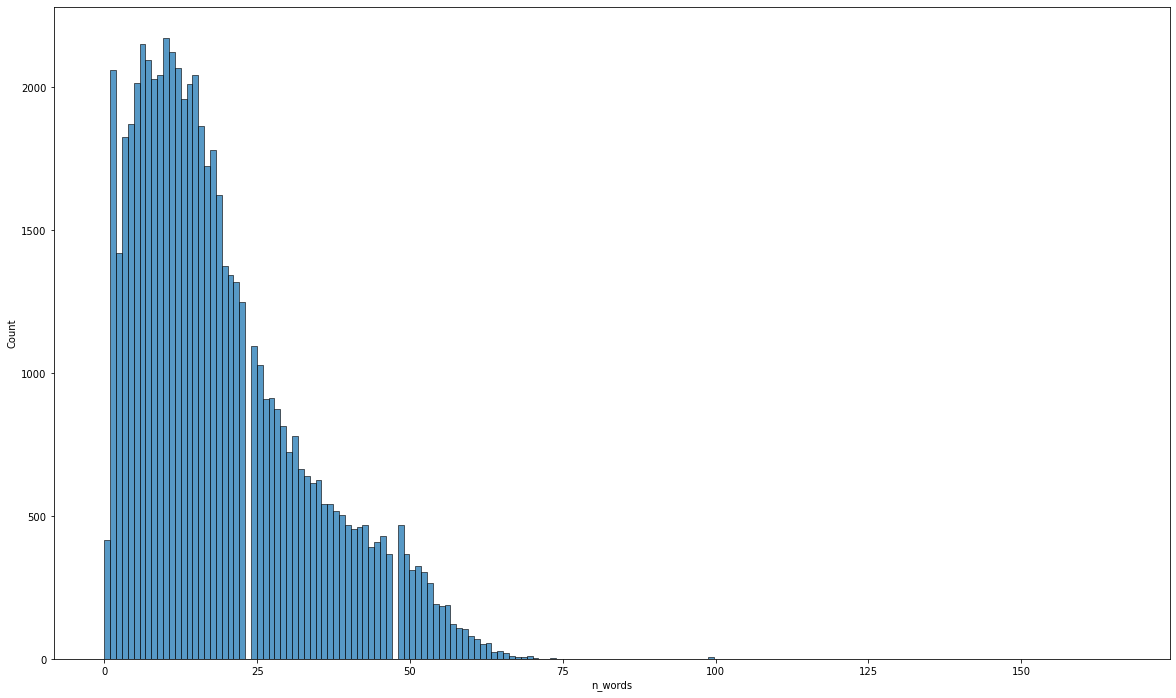

In [12]:
# Fixing size of the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Finding ideal length to use for further process
data_2['n_words'] = data_2['msg'].apply(lambda x:len(x.split()))
sns.histplot(data = data_2, x='n_words')
plt.show()

In [13]:
# So we see above that max no.of words in each sentence is 40
max_len = 50

In [14]:
# Now we need to tokenize the reviews
sentiment = pd.get_dummies(data_2[2])
data_3 = pd.concat([data_2,sentiment],axis=1)
data_3.head()

,2,3,msg,n_words,Negative,Neutral,Positive
0,Positive,im getting on borderlands and i will murder yo...,I m get on borderland and I will murder you all,11,0,0,1
1,Positive,I am coming to the borders and I will kill you...,I be come to the border and I will kill you all,12,0,0,1
2,Positive,im getting on borderlands and i will kill you ...,I m get on borderland and I will kill you all,11,0,0,1
3,Positive,im coming on borderlands and i will murder you...,I m come on borderland and I will murder you all,11,0,0,1
4,Positive,im getting on borderlands 2 and i will murder ...,I m get on borderland and I will murder you I all,12,0,0,1


In [15]:
# Drop columns no longer needed 
data_3.drop(columns=[2,3,'n_words'],inplace=True)

# Tokenizing and padding

Now we will tokenize the words, it means we will conver the words into numbers as machine learning models does not understand string values, and we will pad the resultant tokenzied words to bring all the tokenized words to same length of 40 words.

In [16]:
# now we will tokenize the words to sequence so that our model can understand
# we will also pad the sentences with less than 40 words to make size of each sentence equal
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(data_3['msg'].values)
sequences = tokenizer.texts_to_sequences(data_3['msg'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len, padding='post')

Found 21716 unique tokens.


In [17]:
# Lets see how is our output
# Here 0's at ending are defined due to the padding
X[1000]

array([ 2071, 17179,  4391,  1620,     4,    45,     7,   605,   402,
       15959,    17,   126,     3,    15,   273,   283,    17,  4564,
        7029,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [18]:
# for target we will take postive, negative and neutral columns from data_3
y=data_3[['Negative','Neutral','Positive']]
y.shape

(61121, 3)

# Splitting the data

Now we have cleaned the data, its time to split the data as training and testing, training data will help in training of the data and testing will help to validate how good our model is able to perform on new data.

In [19]:
# splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape,X_test.shape

((60509, 50), (612, 50))

# Creating our Model

Now as our data is ready, it's time to create our model.

We are using tensorflow's keras library to build our model. here are the following modules used in creating of our model

**Sequential** - "tensorflow.keras.models.Sequential" is a class in the TensorFlow Keras API that allows users to create a neural network model by stacking layers sequentially. This means that the output of one layer is fed as input to the next layer.

**Embedding** - "tensorflow.keras.layers.Embedding" is a layer in the TensorFlow Keras API that is used to create word embeddings for natural language processing tasks. The Embedding layer maps the input sequence of integers to a sequence of dense vectors, where each integer represents the index of a word in a vocabulary.

**SpatialDropout1D** - "tensorflow.keras.layers.SpatialDropout1D" is a layer in the TensorFlow Keras API that applies a type of dropout regularization to the inputs of a 1D convolutional neural network (CNN) for sequence data, such as text or time series data. Dropout is a technique used to prevent overfitting in neural networks, by randomly dropping out (setting to zero) some of the neurons in a layer during training.

**LSTM** - LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) layer in TensorFlow that is commonly used for processing sequential data such as text or time series. LSTM is designed to overcome the limitations of traditional RNNs, which have difficulty with long-term dependencies, and are prone to the vanishing gradient problem.

**Dense** - "Dense" is a type of layer in TensorFlow that is used in neural networks for mapping an input tensor to an output tensor by performing a matrix multiplication and an activation function on the input. The Dense layer is a fully connected layer, meaning that each neuron in the layer is connected to every neuron in the previous layer.

**ModelCheckpoint** - "ModelCheckpoint" is a callback function in TensorFlow that allows the model to be saved at specified intervals during training. This is useful for long training runs, where the model may need to be saved periodically to avoid losing progress in the event of an interruption.

**EarlyStopping** - "EarlyStopping" is a callback function in TensorFlow that allows the training of a model to be stopped early based on a specified metric. This can be useful when training a model for a long time, as it allows us to stop training when the performance on a validation set is no longer improving, thus saving time and computational resources.

In [20]:
# Here n_most_words = 23091(vocab_size)+1
n_most_words = len(word_index) + 1
n_dim = 50

# Now we create our model
model = Sequential()
model.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(100,dropout=0.25,recurrent_dropout=0.25))
model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1085850   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 78        
Total params: 1,152,653
Trainable params: 1,152,653
Non-trainable params: 0
______________________________________________

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)
model_history = model.fit(X_train,y_train,epochs=30,validation_split = 0.1, batch_size = 128 ,callbacks=[checkpoint,early_stop])

Epoch 1/30
426/426 [==============================] - 103s 232ms/step - loss: 0.9190 - acc: 0.5397 - val_loss: 0.7207 - val_acc: 0.7007
Epoch 2/30
426/426 [==============================] - 98s 231ms/step - loss: 0.5726 - acc: 0.7744 - val_loss: 0.4798 - val_acc: 0.8156
Epoch 3/30
426/426 [==============================] - 98s 229ms/step - loss: 0.4124 - acc: 0.8440 - val_loss: 0.4143 - val_acc: 0.8442
Epoch 4/30
426/426 [==============================] - 98s 231ms/step - loss: 0.3415 - acc: 0.8729 - val_loss: 0.3622 - val_acc: 0.8642
Epoch 5/30
426/426 [==============================] - 99s 233ms/step - loss: 0.2968 - acc: 0.8893 - val_loss: 0.3420 - val_acc: 0.8673
Epoch 6/30
426/426 [==============================] - 98s 230ms/step - loss: 0.2739 - acc: 0.8966 - val_loss: 0.3441 - val_acc: 0.8757
Epoch 7/30
426/426 [==============================] - 97s 228ms/step - loss: 0.2499 - acc: 0.9047 - val_loss: 0.3421 - val_acc: 0.8810
Epoch 8/30
426/426 [==============================] - 

# Validating model performance and visualizing it

Now our model is trained lets check how it performs on our test data and visualize it in form of graph based on each epoch

In [22]:
# Checking the model loss and accuracy
model.load_weights('weights.hdf5')
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20/20 [==============================] - 0s 15ms/step - loss: 0.2716 - acc: 0.9003
Test set
  Loss: 0.272
  Accuracy: 0.900


In [23]:
# Visualizing the result 
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

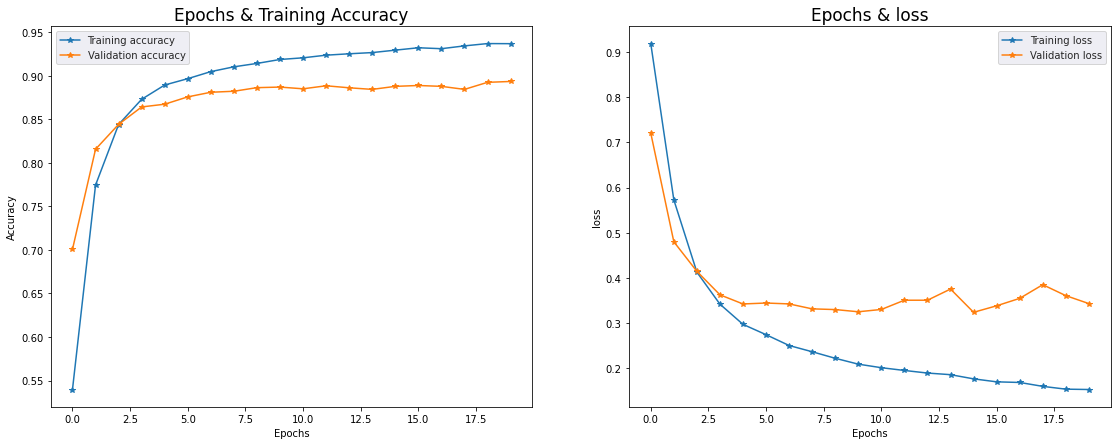

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# Using our model for real world problem

Now we have validated our model and are satisfied with results, lets make use it and see how it performs in real-world problem, we have also created a funtion which takes tweet as input and gives out sentiment of the tweet.

In [35]:
# defining funtion to give us prediction of a sentence 
def find_sentiment(review):
    review = cleaned_review(str(review))
    seq = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    label = ['Negative','Neutral','Positive']
    return label[np.argmax(pred)]

In [36]:
# checking with taining data
data.iloc[1000]

0                                                 2578
1                                          Borderlands
2                                             Negative
3    @ EpicGames @ 2K @ Steam Why add a crossplay f...
Name: 1004, dtype: object

In [37]:
# Checking our funtion if it gives out same result as we expect
print(find_sentiment(["@ EpicGames @ 2K @ Steam Why add a crossplay for @ Borderlands 3 if you're not going to make it compatible for the console?"]))

Negative


In [38]:
# Now reading a data-frame which has tweets that were not trained on model
v_data = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',header=None)
v_data.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [39]:
# Removing irrelavent from column 2 as we didnt use those to predict
v_data = v_data[v_data[2]!='Irrelevant']

In [40]:
# Finding the final prediction on validation set, final column "predicted" is where our models output is stored
v_data['predicted'] = v_data[3].apply(lambda x:find_sentiment([x]))
v_data.head(10)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,0,1,2,3,predicted
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Negative
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,Positive
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",Positive
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,Positive
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...,Negative
10,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...,Positive
